In [7]:
import os
import requests
from PIL import Image, ImageDraw
from io import BytesIO
import pandas as pd
import cairosvg
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random

In [8]:
DS_PATH = "../ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"
output_dir_img_svg="images_png"


# 1. Carga de datos

### 1.1 Datos Json

In [9]:

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


### 1.2 Descarga y converison de los svg

In [10]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesa una imagen para ser utilizada en una red neuronal.
    - Redimensiona la imagen al tamaño deseado.
    - Normaliza los valores de los píxeles entre 0 y 1.

    Args:
        image_path (str): Ruta de la imagen a preprocesar.
        target_size (tuple): Tamaño al cual redimensionar la imagen (ancho, alto).

    Returns:
        Image: Imagen preprocesada lista para ser usada en la red neuronal.
    """
    try:
        # Abrir la imagen
        img = Image.open(image_path)
        
        # Redimensionar la imagen al tamaño objetivo
        img = img.resize(target_size)
        
        # Convertir la imagen a un array de numpy y normalizar los valores de píxeles entre 0 y 1
        img_array = np.array(img) / 255.0
        
        # Convertir nuevamente a imagen con los valores normalizados
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except Exception as e:
        print(f"Error preprocesando la imagen {image_path}: {e}")
        return None

# def download_and_convert_images(df, output_dir="images"):
#     """
#     Descarga las imágenes desde las URLs del DataFrame, las convierte a PNG, las preprocesa y las guarda con el nombre basado en english_name.

#     Args:
#         df (DataFrame): DataFrame que contiene las columnas 'english_name' y 'img_url'.
#         output_dir (str): Directorio donde se guardarán las imágenes.
#     """
#     # Iterar sobre cada fila del DataFrame
#     for index, row in df.iterrows():
#         english_name = row['english_name'].replace(" ", "_").lower()  # Reemplazar espacios por guiones bajos y poner en minúsculas
#         img_url = row['img_url']
        
#         # Crear el directorio de salida específico para cada etiqueta si no existe
#         label_dir = os.path.join(output_dir, english_name)
#         if os.path.exists(label_dir):
#             print(f"El directorio {label_dir} ya existe, se omite el procesamiento para esta etiqueta.")
#             continue
#         else:
#             os.makedirs(label_dir)
        
#         try:
#             # Descargar la imagen desde la URL
#             response = requests.get(img_url, stream=True)
#             response.raise_for_status()
            
#             # Verificar que la respuesta sea de tipo imagen/svg
#             if 'image/svg+xml' in response.headers.get('Content-Type', ''):
#                 # Convertir la imagen SVG a PNG directamente usando cairosvg
#                 png_output_path = os.path.join(label_dir, f"{english_name}.png")
#                 cairosvg.svg2png(bytestring=response.content, write_to=png_output_path)
                
#                 # Preprocesar la imagen
#                 preprocessed_image = preprocess_image(png_output_path)
#                 if preprocessed_image is not None:
#                     # Guardar la imagen preprocesada en formato PNG
#                     preprocessed_image.save(png_output_path, "PNG")
#                     print(f"Imagen preprocesada guardada: {png_output_path}")
#                 else:
#                     print(f"Error al preprocesar la imagen: {png_output_path}")
#             else:
#                 print(f"La URL no contiene una imagen SVG: {img_url}")
#         except requests.exceptions.RequestException as e:
#             print(f"Error descargando {img_url}: {e}")
#         except Exception as e:
#             print(f"Error procesando la imagen {english_name}: {e}")

# def preprocess_image(image_path, target_size=(224, 224)):
#     """
#     Preprocesa una imagen para ser utilizada en una red neuronal.
#     - Redimensiona la imagen al tamaño deseado.
#     - Normaliza los valores de los píxeles entre 0 y 1.

#     Args:
#         image_path (str): Ruta de la imagen a preprocesar.
#         target_size (tuple): Tamaño al cual redimensionar la imagen (ancho, alto).

#     Returns:
#         Image: Imagen preprocesada lista para ser usada en la red neuronal.
#     """
#     try:
#         # Abrir la imagen
#         img = Image.open(image_path).convert("RGB")  # Asegurarse de que la imagen esté en modo RGB
        
#         # Redimensionar la imagen al tamaño objetivo
#         img = img.resize(target_size)
        
#         # Convertir la imagen a un array de numpy y normalizar los valores de píxeles entre 0 y 1
#         img_array = np.array(img) / 255.0
        
#         # Convertir nuevamente a imagen con los valores normalizados
#         img = Image.fromarray((img_array * 255).astype(np.uint8))
        
#         return img
#     except Exception as e:
#         print(f"Error preprocesando la imagen {image_path}: {e}")
#         return None

def download_and_convert_images(df, output_dir="images"):
    """
    Descarga las imágenes desde las URLs del DataFrame, las convierte a PNG, las preprocesa y las guarda con el nombre basado en english_name.

    Args:
        df (DataFrame): DataFrame que contiene las columnas 'english_name' y 'img_url'.
        output_dir (str): Directorio donde se guardarán las imágenes.
    """
    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        english_name = row['english_name'].replace(" ", "_").lower()  # Reemplazar espacios por guiones bajos y poner en minúsculas
        img_url = row['img_url']
        
        # Crear el directorio de salida específico para cada etiqueta si no existe
        label_dir = os.path.join(output_dir, english_name)
        if os.path.exists(label_dir):
            print(f"El directorio {label_dir} ya existe, se omite el procesamiento para esta etiqueta.")
            continue
        else:
            os.makedirs(label_dir)
        
        try:
            # Descargar la imagen desde la URL
            response = requests.get(img_url, stream=True)
            response.raise_for_status()
            
            # Verificar que la respuesta sea de tipo imagen/svg
            if 'image/svg+xml' in response.headers.get('Content-Type', ''):
                # Convertir la imagen SVG a PNG directamente usando cairosvg
                png_output_path = os.path.join(label_dir, f"{english_name}.png")
                cairosvg.svg2png(bytestring=response.content, write_to=png_output_path)
                
                # Preprocesar la imagen
                preprocessed_image = preprocess_image(png_output_path)
                if preprocessed_image is not None:
                    # Guardar la imagen preprocesada en formato PNG
                    preprocessed_image.save(png_output_path, "PNG")
                    print(f"Imagen preprocesada guardada: {png_output_path}")
                else:
                    print(f"Error al preprocesar la imagen: {png_output_path}")
            else:
                print(f"La URL no contiene una imagen SVG: {img_url}")
        except requests.exceptions.RequestException as e:
            print(f"Error descargando {img_url}: {e}")
        except Exception as e:
            print(f"Error procesando la imagen {english_name}: {e}")

def augment_images(data_dir="images", augment_dir="augmented_images", augment_count=20, target_size=(224, 224)):
    """
    Aumenta las imágenes disponibles creando múltiples versiones con transformaciones y añadiendo fondos aleatorios.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes originales.
        augment_dir (str): Directorio donde se guardarán las imágenes aumentadas.
        augment_count (int): Número de imágenes aumentadas a generar por cada imagen original.
        target_size (tuple): Tamaño al cual redimensionar las imágenes (ancho, alto).
    """
    # Realizar aumentación solo si el directorio de imágenes aumentadas no existe
    if os.path.exists(augment_dir):
        print(f"El directorio {augment_dir} ya existe, se omite la aumentación de imágenes.")
        return
    else:
        os.makedirs(augment_dir)
    
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Iterar sobre cada carpeta de categoría en el directorio de datos
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        
        # Crear la carpeta de destino para las imágenes aumentadas si no existe
        augment_label_dir = os.path.join(augment_dir, label)
        if not os.path.exists(augment_label_dir):
            os.makedirs(augment_label_dir)
        
        # Iterar sobre cada imagen en la carpeta de categoría
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGBA")  # Convertir a RGBA para asegurar que tiene canal alfa
                img = img.resize(target_size)
                
                for _ in range(augment_count):
                    # Crear un fondo aleatorio para cada aumentación
                    background = Image.new("RGBA", target_size, (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 255))
                    
                    # Combinar la imagen con el fondo
                    combined = Image.alpha_composite(background, img).convert("RGB")
                    img_array = np.array(combined)
                    
                    # Verificar y ajustar la forma del array para asegurarse de que tiene las dimensiones correctas
                    if len(img_array.shape) == 2:  # Imágenes en escala de grises
                        img_array = np.stack((img_array,)*3, axis=-1)  # Convertir a RGB duplicando los canales
                    elif img_array.shape[-1] != 3:  # Si no tiene 3 canales
                        print(f"Advertencia: La imagen {img_path} no tiene 3 canales. Se omite la aumentación.")
                        continue
                    
                    img_array = img_array.reshape((1, target_size[0], target_size[1], 3)) / 255.0
                    
                    # Generar una imagen aumentada y guardarla
                    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augment_label_dir, save_prefix=label, save_format='png'):
                        break
            except Exception as e:
                print(f"Error aumentando la imagen {img_path}: {e}")

In [11]:
download_and_convert_images(df,output_dir_img_svg)
augment_images(output_dir_img_svg)

Imagen preprocesada guardada: images_png/boat/boat.png
Imagen preprocesada guardada: images_png/half-boat/half-boat.png
Imagen preprocesada guardada: images_png/bow/bow.png
Imagen preprocesada guardada: images_png/bridge/bridge.png
Imagen preprocesada guardada: images_png/butterfly/butterfly.png
Imagen preprocesada guardada: images_png/camel/camel.png
Imagen preprocesada guardada: images_png/cat/cat.png
Imagen preprocesada guardada: images_png/cow/cow.png
Imagen preprocesada guardada: images_png/chair/chair.png
Imagen preprocesada guardada: images_png/child's_pose/child's_pose.png
Imagen preprocesada guardada: images_png/corpse/corpse.png
Imagen preprocesada guardada: images_png/crescent_lunge/crescent_lunge.png
Imagen preprocesada guardada: images_png/crow/crow.png
Imagen preprocesada guardada: images_png/dolphin/dolphin.png
Imagen preprocesada guardada: images_png/downward-facing_dog/downward-facing_dog.png
Imagen preprocesada guardada: images_png/eagle/eagle.png
Imagen preprocesada 

### 2 Entrenamiento de la CNN

In [12]:
def plot_metrics(history):
    """
    Grafica la pérdida y precisión del entrenamiento y validación.
    
    Parámetros:
    - history: objeto de historial devuelto por el método fit() de Keras.
    """
    # Crear la figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfica de Pérdida
    ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    if('val_loss' in history.history):
        ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
    ax1.set_title('Pérdida durante el Entrenamiento')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfica de Precisión
    ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    if('val_accuracy' in history.history):
        ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
    ax2.set_title('Precisión durante el Entrenamiento')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    # Mostrar la figura
    plt.show()

In [13]:
def build_functional_cnn_model(input_shape, num_classes):
    """
    Construye un modelo de red neuronal convolucional utilizando la API funcional de Keras.

    Args:
        input_shape (tuple): Forma de la entrada del modelo (altura, ancho, canales).
        num_classes (int): Número de clases para la clasificación.

    Returns:
        Model: Modelo de Keras compilado listo para ser entrenado.
    """
    # Definir la entrada
    inputs = layers.Input(shape=input_shape)

    # Primer bloque de capas
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Segundo bloque de capas
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)
    
    # Tercer bloque de capas
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Global Average Pooling en lugar de Flatten para reducir parámetros
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Capa densa final con salida para la clasificación
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Definir el modelo
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def train_cnn_with_augmentation(data_dir="augmented_images", target_size=(224, 224), batch_size=4, epochs=10):
    """
    Entrena una CNN usando las imágenes con aumentación para mejorar la generalización del modelo.

    Args:
        data_dir (str): Directorio donde están almacenadas las imágenes preprocesadas y aumentadas.
        target_size (tuple): Tamaño al cual redimensionar las imágenes (ancho, alto).
        batch_size (int): Tamaño del batch para el entrenamiento.
        epochs (int): Número de épocas para el entrenamiento.
    Returns:
        History: Objeto de historial de entrenamiento de Keras.
    """
    # Liberar memoria de la GPU antes de iniciar el entrenamiento
    tf.keras.backend.clear_session()

    # Generador de aumentación de imágenes
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=0.2  # Dividir el conjunto de datos para validación
    )

    # Crear el generador para las imágenes de entrenamiento
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True  # Asegurar que los datos estén mezclados
    )

    # Crear el generador para las imágenes de validación
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # Desactivar shuffle para validación
    )

    # Verificar que los generadores no estén vacíos
    if train_generator.samples == 0 or validation_generator.samples == 0:
        print("Error: No hay suficientes datos en los conjuntos de entrenamiento o validación.")
        return None

    # Construir el modelo usando la API funcional
    model = build_functional_cnn_model(input_shape=(target_size[0], target_size[1], 3), num_classes=train_generator.num_classes)

    # Entrenar el modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Devolver el historial de entrenamiento
    return history

In [14]:
history = train_cnn_with_augmentation()



Found 768 images belonging to 48 classes.
Found 192 images belonging to 48 classes.


I0000 00:00:1730276112.077411    1724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730276112.224994    1724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730276112.225047    1724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730276112.229519    1724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730276112.229585    1724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730276116.028431    4847 service.cc:146] XLA service 0x7f7d7801bae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730276116.028468    4847 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-10-30 08:15:16.138142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 08:15:16.513954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  3/192 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0000e+00 - loss: 4.9477 

2024-10-30 08:15:22.165612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_9', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1730276122.197892    4847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.0121 - loss: 4.4811 - val_accuracy: 0.0156 - val_loss: 4.3581
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0168 - loss: 4.2224 - val_accuracy: 0.0156 - val_loss: 4.4014
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0200 - loss: 4.1279 - val_accuracy: 0.0677 - val_loss: 4.2755
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0445 - loss: 4.0315 - val_accuracy: 0.0573 - val_loss: 4.0826
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0527 - loss: 3.9456 - val_accuracy: 0.0260 - val_loss: 3.9241
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0575 - loss: 3.9250 - val_accuracy: 0.0365 - val_loss: 3.9402
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0428 - loss: 3.8423 - val_accuracy: 0.0573 - val_loss: 3.8049
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0376 - loss: 3.8541 - val_accuracy: 0.04

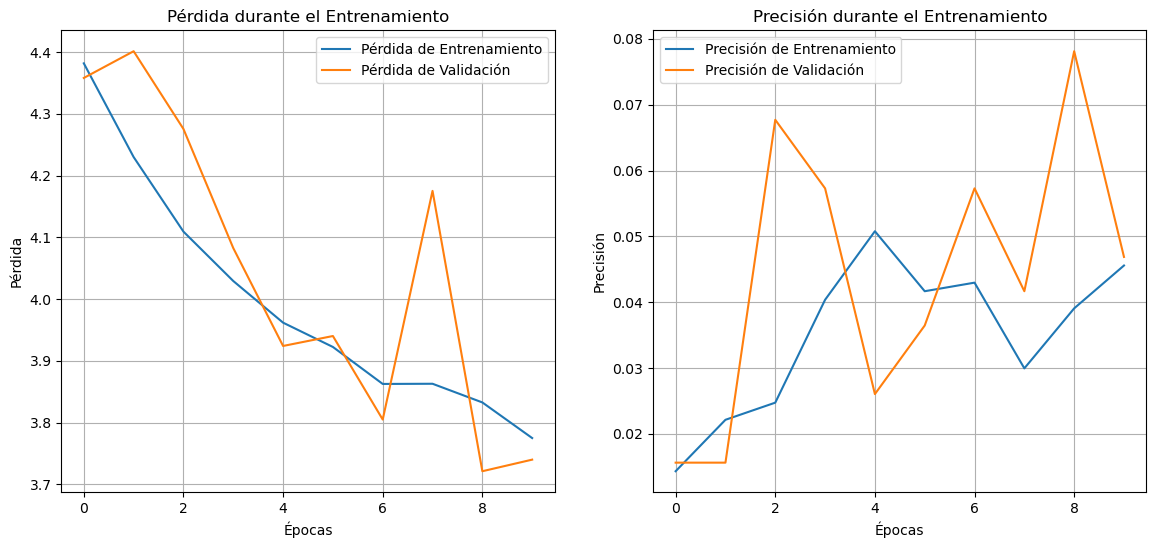

In [16]:
plot_metrics(history)